In [55]:
import kagglehub

path = kagglehub.dataset_download('jamieleech/boston-housing-dataset')
print('path to dataset files:', path)

path to dataset files: /kaggle/input/boston-housing-dataset


In [56]:
!ls /root/.cache/kagglehub/datasets/jamieleech/boston-housing-dataset/versions/2

housing.csv


In [57]:
import pandas as pd

data = pd.read_csv('/root/.cache/kagglehub/datasets/jamieleech/boston-housing-dataset/versions/2/housing.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [58]:
data.shape

(506, 14)

In [59]:
data.isnull().sum()

,0
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [60]:
pearson = data.corr(method='pearson')
pearson['MEDV'].drop('MEDV').sort_values(ascending=False)

,MEDV
RM,0.695360
ZN,0.360445
B,0.333461
DIS,0.249929
CHAS,0.175260
AGE,-0.376955
RAD,-0.381626
CRIM,-0.388305
NOX,-0.427321
TAX,-0.468536


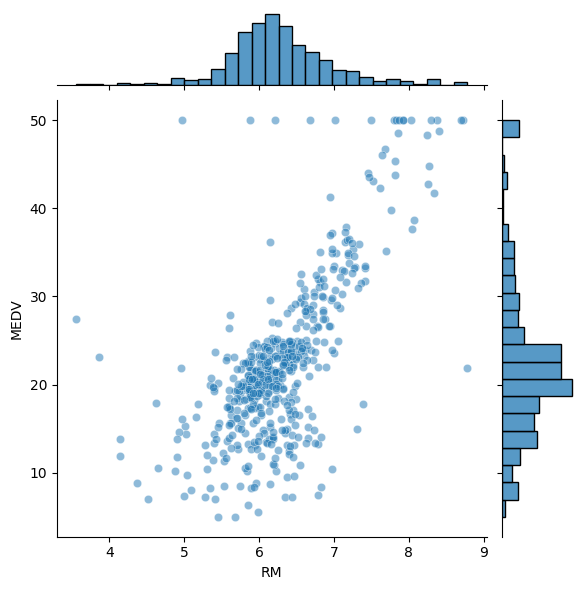

In [61]:
import seaborn as sns

sns.jointplot(data, x='RM', y='MEDV', kind='scatter', joint_kws={'alpha': 0.5})

In [62]:
data[['RM', 'MEDV']].describe()

,RM,MEDV
count,506.000000,506.000000
mean,6.284634,22.532806
std,0.702617,9.197104
min,3.561000,5.000000
25%,5.885500,17.025000
50%,6.208500,21.200000
75%,6.623500,25.000000
max,8.780000,50.000000


In [63]:
data.MEDV.tolist().count(50)

16

In [64]:
import numpy as np
from tqdm.auto import tqdm


class GDRegressor:
    def __init__(self, alpha=0.001, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.progress = progress

    def fit(self, X_train, y_train):
        X = np.array(X_train)
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        y = np.array(y_train).reshape(-1)

        m, n_features = X.shape

        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0

        self.theta_history = {
            'coef': [[] for _ in range(n_features)],
            'intercept': []
        }

        self.loss_history = []

        iterator = tqdm(
            range(self.n_iter),
            disable=not self.progress,
            desc='GDRegressor fitting'
        )

        for _ in iterator:
            y_pred = X.dot(self.coef_) + self.intercept_
            errors = y_pred - y

            grad_coef_ = (1/m) * (X.T.dot(errors))
            grad_intercept_ = (1/m) * np.sum(errors)
            self.coef_ -= self.alpha * grad_coef_
            self.intercept_ -= self.alpha * grad_intercept_

            for i in range(n_features):
                self.theta_history['coef'][i].append(self.coef_[i])
            self.theta_history['intercept'].append(self.intercept_)

            loss = (1/(2*m)) * (errors**2).sum()

            self.loss_history.append(loss)

            if self.progress:
                iterator.set_postfix(loss=loss)

        return self

    def predict(self, X_test):
        X = np.array(X_test)
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        return X.dot(self.coef_) + self.intercept_

In [65]:
from sklearn.model_selection import train_test_split

X = data[['RM']]
y = data['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)

model = GDRegressor(alpha=0.04, n_iter=2000)
%time model.fit(X_train, y_train)
print(model.coef_, model.intercept_)

GDRegressor fitting:   0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 352 ms, sys: 21 ms, total: 373 ms
Wall time: 395 ms
[7.07554766] -21.79244730287655


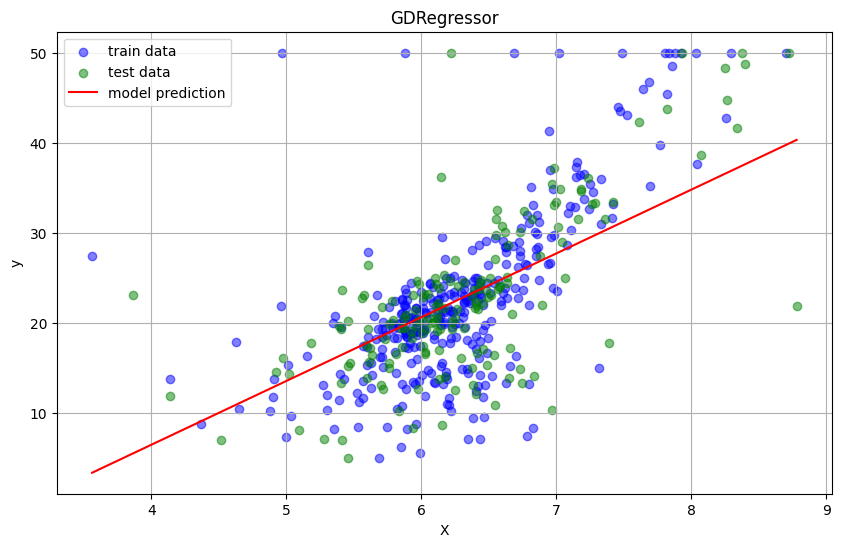

In [66]:
import matplotlib.pyplot as plt

def plot_results(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train).reshape(-1, 1)
    y_train = np.array(y_train).reshape(-1)
    X_test = np.array(X_test).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1)

    x_all = np.vstack((X_train, X_test))
    x_line = np.linspace(x_all.min(), x_all.max(), 100).reshape(-1, 1)
    y_line = model.predict(x_line)

    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, y_train, color='blue', label='train data', alpha=0.5)
    plt.scatter(X_test, y_test, color='green', label='test data', alpha=0.5)
    plt.plot(x_line, y_line, color='red', label='model prediction')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('GDRegressor')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_results(X_train, y_train, X_test, y_test)

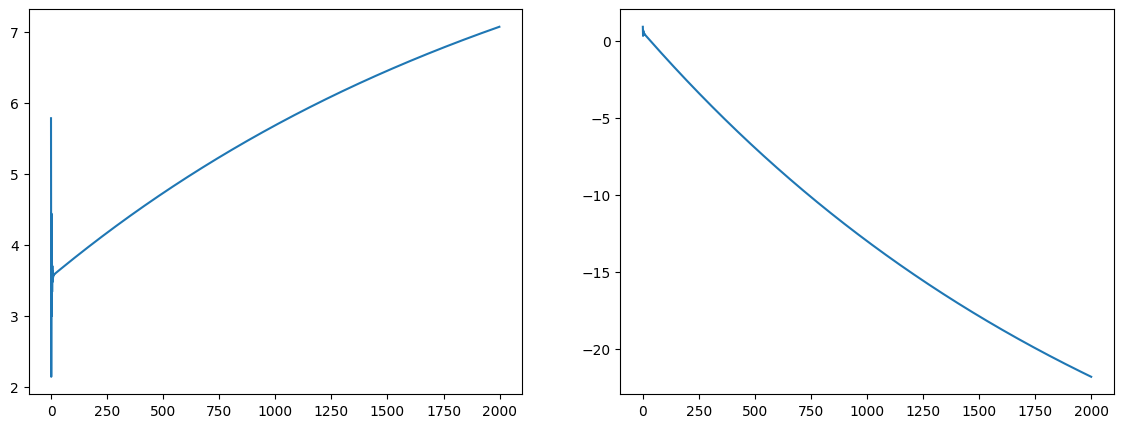

In [67]:
def plot_coeffs(model):
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    plt.plot(list(range(model.n_iter)), model.theta_history['coef'][0])
    plt.subplot(122)
    plt.plot(list(range(model.n_iter)), model.theta_history['intercept'])


plot_coeffs(model)

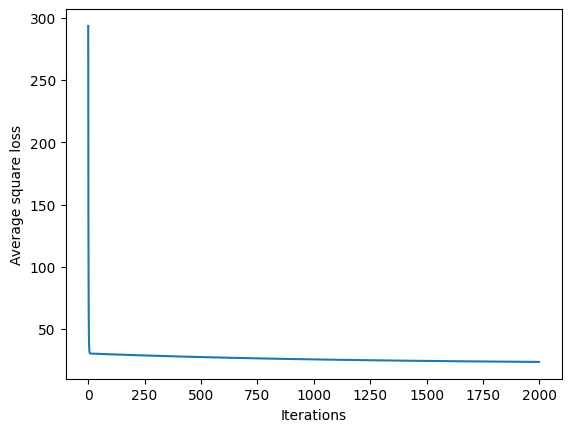

In [68]:
def plot_loss_function(model):
    plt.xlabel('Iterations')
    plt.ylabel('Average square loss')
    plt.plot(np.arange(model.n_iter), model.loss_history)


plot_loss_function(model)

In [69]:
def rmse(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def r_squared(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)

    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)

    return 1 - ss_res / ss_tot


y_pred = model.predict(X_test)
rmse(y_test, y_pred), r_squared(y_test, y_pred)

(np.float64(6.500256917031143), np.float64(0.48822629468823353))

GDRegressor fitting:   0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 504 ms, sys: 8.53 ms, total: 513 ms
Wall time: 1.01 s
[5.72605092] -14.204000519369515
6.050413914442002 0.48732429177493897


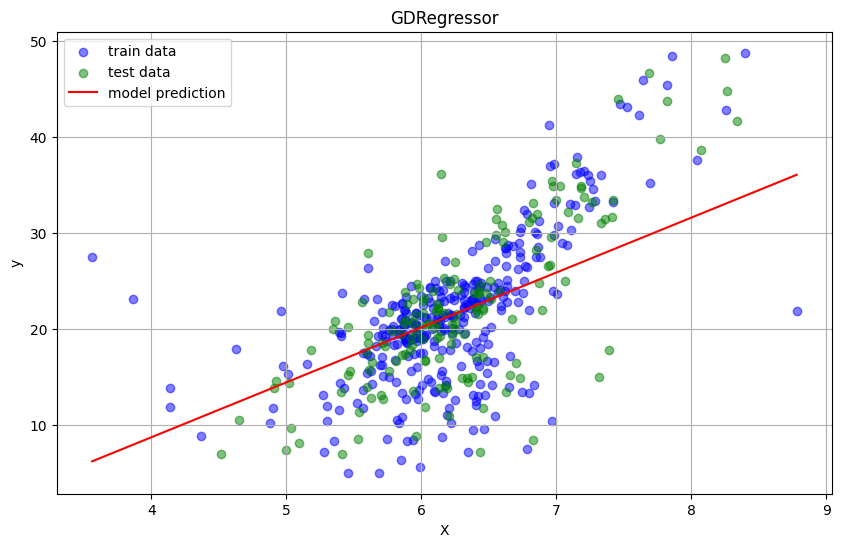

In [72]:
data = data[data['MEDV'] != 50]
X = data[['RM']]
y = data['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)

model = GDRegressor(alpha=0.04, n_iter=2000)
%time model.fit(X_train, y_train)
print(model.coef_, model.intercept_)

y_pred = model.predict(X_test)
print(rmse(y_test, y_pred), r_squared(y_test, y_pred))

plot_results(X_train, y_train, X_test, y_test)

In [73]:
n_iters = range(500, 5001, 500)
alphas = (0.1, 0.05, 0.04, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001)

best_alpha = 0.04
best_n_iter = 2000
best_rmse = float('inf')

for a in alphas:
  for n in n_iters:
    model = GDRegressor(alpha=a, n_iter=n, progress=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    curr_rmse = rmse(y_test, y_pred)
    if curr_rmse < best_rmse:
      best_alpha = a
      best_n_iter = n
      best_rmse = curr_rmse

print(best_alpha, best_n_iter)

model = GDRegressor(alpha=best_alpha, n_iter=best_n_iter, progress=False)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse(y_test, y_pred), r_squared(y_test, y_pred)

0.04 5000


(np.float64(5.738086135491282), np.float64(0.538887713617576))

In [75]:
def z_scaler(feature):
    mean = feature.mean()
    std = feature.std()
    return (feature - mean) / std


def min_max(feature):
    mn = feature.min()
    mx = feature.max()
    diff = mx - mn
    return (feature - mn) / diff

X = z_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)

model = GDRegressor(alpha=best_alpha, n_iter=best_n_iter)
%time model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(rmse(y_test, y_pred), r_squared(y_test, y_pred))

X = data[['RM']]
X = min_max(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)

model = GDRegressor(alpha=best_alpha, n_iter=best_n_iter)
%time model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse(y_test, y_pred), r_squared(y_test, y_pred)

GDRegressor fitting:   0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 918 ms, sys: 51.6 ms, total: 970 ms
Wall time: 981 ms
5.6446759470666485 0.5537783916839258


GDRegressor fitting:   0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 786 ms, sys: 47.3 ms, total: 833 ms
Wall time: 853 ms


(np.float64(5.740110678482542), np.float64(0.5385622718886891))

In [80]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error

X = data[['RM']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 18)

model = make_pipeline(
    StandardScaler(),
    SGDRegressor(
        loss='squared_error',
        penalty='l2',
        alpha=1e-3,
        learning_rate='invscaling',
        eta0=1e-2,
        power_t=0.25,
        max_iter=5000,
        tol=1e-4,
        shuffle=True,
        random_state=42
    )
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
root_mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

(5.64438886451916, 0.5538237792950766)